# 89-integer-production-resources

# Test the solution method
Make sure that we are finding the optimal point

## Set up basic production system

In [1]:
import itertools
import numpy as np
from collections import OrderedDict as OD

from gpkit import Model, Variable

from gpx.manufacturing import QNACell, FabLine, ConwipTooling
from gpx.primitives import Process


In [2]:
from operator import itemgetter

In [3]:
# create some processesc
process_times = [
    ('first', 15),
    ('second', 20),
    ('third', 25),
]

processes_times = OD()
for pt in process_times:
    processes_times[pt[0]] = pt[1]

cv = Variable('CV', 0.5, '-', 'coeffcient of variation')

# create processes
processes = {name: Process(cv=cv) for name,time in processes_times.items()}

In [4]:
# make cells from processes
cells = OD()
for name in processes_times.keys():
    cells[name] = QNACell(processes[name])
# cells = {name: QNACell(proc) for name,proc in processes.items()}

called GPX model  23
called GPX model  23
called GPX model  23


In [5]:
# make the fab line
line = FabLine(list(cells.values()))

called GPX model  23


In [6]:
# create constraints
constr = [line]

# make the costs
costs = np.sum([c.m for c in cells.values()]) + line.L

# create the model
m = Model(costs, constr)

In [7]:
# substitutions
## process times
m.substitutions.update({proc.t : processes_times[name] for name,proc in processes.items()})

## rate
m.substitutions[line.lam] = 7

## CV
m.substitutions[cv] = 0.75

In [8]:
print(m.solve().table())

Using solver 'cvxopt'
 for 32 free variables
  in 34 posynomial inequalities.
Solving took 0.887 seconds.

             ┃┓             ┓           ┓
             ┃┃             ┃           ┃
             ┃┃             ┃           ┣╸QNACell2.W╶⎨
             ┃┃             ┃           ┛ (33.1min)
             ┃┃             ┃           ┓
             ┃┣╸L           ┣╸FabLine.W ┣╸QNACell1.W╶⎨
             ┃┃ (9.46count) ┃ (1.35hr)  ┛ (27.1min)
             ┃┃             ┃           ┓
             ┃┃             ┃           ┣╸QNACell.W╶⎨
        Cost╺┫┛             ┛           ┛ (20.9min)
 (19.7count) ┃┓             ┓
             ┃┃             ┃
             ┃┣╸QNACell2.m  ┣╸Process3.t
             ┃┛ (4.14count) ┛ (25min, fixed)
             ┃┓             ┓
             ┃┣╸QNACell1.m  ┣╸Process2.t
             ┃┛ (3.42count) ┛ (20min, fixed)
             ┃┓             ┓
             ┃┣╸QNACell.m   ┣╸Process1.t
             ┃┛ (2.68count) ┛ (15min, fixed)



       ┃┓         ┓
    

## Find all system configs

In [9]:
range_wip = np.arange(8,12)
range_cell = np.arange(2,6)

In [10]:
thing = [range_cell]*3
thing.append(range_wip)

In [11]:
# find the combinations
test_step = list(itertools.product(*thing))[0]

In [12]:
# update the model to mximize rate
m.cost = 1.0/line.lam

# delete the substitution for rate
del m.substitutions[line.lam]

In [13]:
m.substitutions

{QNACell.\eta_t: 1,
 QNACell.\chi_{cv}: 1,
 QNACell1.\chi_{cv}: 1,
 QNACell1.\eta_t: 1,
 QNACell2.\eta_t: 1,
 QNACell2.\chi_{cv}: 1,
 Process1.t: 15,
 Process2.t: 20,
 Process3.t: 25,
 CV: 0.75}

In [14]:
# update with the substitution step
## update cell counts
m.substitutions.update({cell.m : test_step[i] for i,cell in enumerate(cells.values())})
m.substitutions[line.L] = test_step[-1]

In [15]:
print(m.solve().table())

Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.625 seconds.

                 ┃┓
            Cost╺┫┃
 (0.244hr/count) ┃┣╸1/FabLine.\lambda
                 ┃┛ (0.244hr/count)



       ┃┓          ┣╸\eta_t = 1
       ┃┃          ┛
       ┃┃          ┣╸t_{\eta} ≥ Process3.t·\eta_t
       ┃┃          ┛
       ┃┣╸QNACell2 ┣╸m = 2count
       ┃┃          ┛
       ┃┃          ┣╸\lambda ≤ rho·m/t_{\eta}
       ┃┃          ┣╸\alpha + rho ≤ 1
       ┃┛          ┣╸[5 terms]
 Model╺┫┓
       ┃┃
       ┃┣╸FabLine╶⎨
       ┃┛
       ┃┣╸QNACell1╶⎨
       ┃┛
       ┃┣╸Process3 ┣╸t = 25min
       ┃┛          ┛
       ┃┣╸QNACell╶⎨
       ┃┣╸CV = 0.75
       ┃┣╸[2 terms]


Free Variables
--------------
         | FabLine
       W : 1.953   [hr]       Total flow time
 \lambda : 4.095   [count/hr] Line Continuous Production Rate

         | QNACell
       W : 20.26   [min]      Total flow time through cell
      Wq : 5.264   [min]      Expected queueing time


In [16]:
m.solution['cost']**-1

4.095224350910572

In [17]:
# find the results
res = []

for step in itertools.product(*thing):
    # update the substitutions
    m.substitutions.update({cell.m : step[i] for i,cell in enumerate(cells.values())})
    m.substitutions[line.L] = step[-1]

    # solve the updated model
    m.solve()

    # store the configuration, the cost, and the rate
    cost = np.sum(step)
    res.append((cost, m.solution['cost']**-1, step))


Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.615 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.442 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.48 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.531 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.431 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.443 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.252 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.273 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.275 seconds.
Using solver 'cvxopt'
 for 29 free variables
  

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

In [19]:
resdf = pd.DataFrame(res, columns=['cost', 'rate', 'step'])

In [20]:
resdf.head()

,cost,rate,step
0,14,4.095224,"(2, 2, 2, 8)"
1,15,4.212698,"(2, 2, 2, 9)"
2,16,4.301031,"(2, 2, 2, 10)"
3,17,4.368829,"(2, 2, 2, 11)"
4,15,4.833234,"(2, 2, 3, 8)"


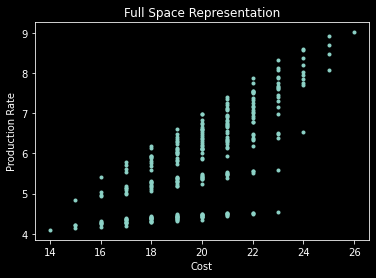

In [21]:
plt.plot(resdf['cost'], resdf['rate'], '.')
plt.title('Full Space Representation')
plt.ylabel('Production Rate')
plt.xlabel('Cost')
plt.show()

In [22]:
# find the frontier of min cost per rate
pareto = pd.DataFrame(resdf.groupby('cost')['rate'].max())

__Cost Pareto__

In [23]:
pareto

,rate
cost,
14,4.095224
15,4.833234
16,5.412719
17,5.780381
18,6.185438
19,6.614393
20,6.989452
21,7.409784
22,7.880280


<Figure size 432x288 with 0 Axes>

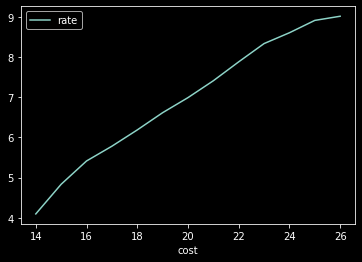

In [24]:
# plot
plt.figure()
pareto.plot()
plt.show()

## SB ToC Implementation

In [25]:
# find the list of the varkeys that will be discrete
discvars = [cell.m for cell in cells.values()]
discvars.append(line.L)

In [26]:
# put the old cost back in
m.cost = costs

for dv in discvars:
    del m.substitutions[dv]


In [27]:
# set the target rate
min_rate = 6.8  # should lead to cost of 23

m.substitutions[line.lam] = min_rate

In [28]:
# solve the continuous
contsol = m.solve()
print(f'bes continuous cost: {contsol["cost"]}')

Using solver 'cvxopt'
 for 32 free variables
  in 34 posynomial inequalities.
Solving took 0.118 seconds.
bes continuous cost: 19.206831502895497


### Test using new SolveDiscrete

In [29]:
from gpx import Model

In [30]:
gm = Model(costs, [line])

called GPX model  23


In [31]:
gm.cost = costs

In [32]:
# update the substitutions
## process times
## process times
gm.substitutions.update({proc.t : processes_times[name] for name,proc in processes.items()})

## rate
gm.substitutions[line.lam] = 7

## CV
gm.substitutions[cv] = 0.75

In [33]:
print(gm.solve().table())

Using solver 'cvxopt'
 for 32 free variables
  in 34 posynomial inequalities.
Solving took 0.123 seconds.

             ┃┓             ┓           ┓
             ┃┃             ┃           ┃
             ┃┃             ┃           ┣╸QNACell2.W╶⎨
             ┃┃             ┃           ┛ (33.1min)
             ┃┃             ┃           ┓
             ┃┣╸L           ┣╸FabLine.W ┣╸QNACell1.W╶⎨
             ┃┃ (9.46count) ┃ (1.35hr)  ┛ (27.1min)
             ┃┃             ┃           ┓
             ┃┃             ┃           ┣╸QNACell.W╶⎨
        Cost╺┫┛             ┛           ┛ (20.9min)
 (19.7count) ┃┓             ┓
             ┃┃             ┃
             ┃┣╸QNACell2.m  ┣╸Process3.t
             ┃┛ (4.14count) ┛ (25min, fixed)
             ┃┓             ┓
             ┃┣╸QNACell1.m  ┣╸Process2.t
             ┃┛ (3.42count) ┛ (20min, fixed)
             ┃┓             ┓
             ┃┣╸QNACell.m   ┣╸Process1.t
             ┃┛ (2.68count) ┛ (15min, fixed)



       ┃┓         ┓
    

In [34]:
gm.substitutions

{QNACell.\eta_t: 1,
 QNACell.\chi_{cv}: 1,
 QNACell1.\chi_{cv}: 1,
 QNACell1.\eta_t: 1,
 QNACell2.\eta_t: 1,
 QNACell2.\chi_{cv}: 1,
 Process1.t: 15,
 Process2.t: 20,
 Process3.t: 25,
 FabLine.\lambda: 7,
 CV: 0.75}

In [35]:
max(1,2)

2

In [36]:
gm.SolveDiscrete(
    discrete_resources=discvars,
    target_variable=line.lam,
    target_value=min_rate,
    new_cost=line.lam**-1
)

Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.117 seconds.
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.104 seconds.
Using solver 'cvxopt'
 for 28 free variables
  in 34 posynomial inequalities.
Solving took 0.132 seconds.


{'cost': 20.000000004993293,
 'cost function': gpkit.Posynomial(QNACell.m + QNACell1.m + QNACell2.m + FabLine.L [count]),
 'freevariables': {FabLine.W: 1.4705882352941178,
  QNACell.c2d: 0.6075176125850074,
  QNACell1.c2a: 0.6338637346973689,
  QNACell1.c2d: 0.619794862463002,
  QNACell2.c2a: 0.6542923214258417,
  QNACell2.c2d: 0.6395232652702549,
  QNACell.c2a: 0.6808140333009176,
  QNACell.\lambda: 6.800000000000001,
  QNACell1.\lambda: 6.800000000000001,
  QNACell2.\lambda: 6.800000000000001,
  QNACell.W: 20.663266182440175,
  QNACell1.W: 32.733452749042335,
  QNACell2.W: 34.78783569790836,
  QNACell.\alpha: 0.3566338296988021,
  QNACell.rho: 0.5784791963118242,
  QNACell.c2s: 0.5868235811643152,
  QNACell.t_{\eta}: 15.038150640580577,
  QNACell.Wq: 5.524218156316313,
  QNACell1.\alpha: 0.2429715635147387,
  QNACell1.rho: 0.7561082082910353,
  QNACell1.c2s: 0.5728087741948154,
  QNACell1.t_{\eta}: 20.00999599082836,
  QNACell1.Wq: 12.674400764890043,
  QNACell2.\alpha: 0.28916736540

### Test Using old method

In [37]:
print('\n'.join([str(m.solution(dv)) for dv in discvars]))

2.615975487476237 count
3.336226561931237 count
4.038264422455254 count
9.216365031346093 count


In [38]:
contsol(line.lam)

6.8 <Unit('count / hour')>

In [39]:
# convert to discrete form
## change cost to rate
m.cost = line.lam**-1

## remove substitutions for line rate
del m.substitutions[line.lam]

In [40]:
# find first discrete point with round-down
m.substitutions.update({
    dv : np.round(contsol(dv))
    for dv in discvars
})

In [41]:
m.substitutions

{QNACell.\eta_t: 1,
 QNACell.\chi_{cv}: 1,
 QNACell1.\chi_{cv}: 1,
 QNACell1.\eta_t: 1,
 QNACell2.\eta_t: 1,
 QNACell2.\chi_{cv}: 1,
 Process1.t: 15,
 Process2.t: 20,
 Process3.t: 25,
 CV: 0.75,
 QNACell.m: 3.0,
 QNACell1.m: 3.0,
 QNACell2.m: 4.0,
 FabLine.L: 9.0}

In [42]:
# find the solution
curRate = m.solve()['cost']
print(f'starting rate {curRate**-1}')

Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.536 seconds.
starting rate 6.6143925040709695


In [43]:
print('\n'.join([str(m.solution(dv)) for dv in discvars]))

3.0 count
3.0 count
4.0 count
9.0 count


In [44]:
sens = [(m.solution['sensitivities']['variables'][dv], dv) for dv in discvars]

In [45]:
sens

[(-0.07259361497554112, gpkit.Variable(QNACell.m [count])),
 (-0.32305163014054844, gpkit.Variable(QNACell1.m [count])),
 (-0.21374405693308185, gpkit.Variable(QNACell2.m [count])),
 (-0.5314919366682489, gpkit.Variable(FabLine.L [count]))]

In [46]:
all([m.solution['sensitivities']['variables'][dv]*-1 > 0 for dv in discvars])

True

In [47]:
# Loop until rate is met
while curRate**-1 < min_rate:
    # find most sensitive
    most_sens = min(
        [(m.solution['sensitivities']['variables'][dv], dv) for dv in discvars],
        key=itemgetter(0)
    )[1]
    print(f'sensitive: {most_sens}')
    # increment
    m.substitutions[most_sens] += 1
    # solve
    curRate = m.solve()['cost']
    print(f'current rate {curRate**-1}')
    

sensitive: FabLine.L [count]
Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.529 seconds.
current rate 6.969748779347492


In [48]:
# print the solution
endSol = m.solution
endRate = curRate**-1
endcost = np.sum([endSol(dv) for dv in discvars])
print(f'endcost : {endcost}')
for dv in discvars:
    print(f'{dv} : {endSol(dv)}')

endcost : 20.0
QNACell.m [count] : 3.0 count
QNACell1.m [count] : 3.0 count
QNACell2.m [count] : 4.0 count
FabLine.L [count] : 10.0 count


/home/user/aa-refactor/aa-venv/py3-dev/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


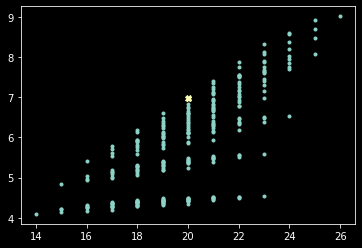

In [49]:
plt.figure()
plt.plot(resdf['cost'], resdf['rate'], '.')
# pareto.plot()
plt.plot(endcost, endRate, 'X', label='SB-ToC')
plt.show()

In [50]:
m.substitutions

{QNACell.\eta_t: 1,
 QNACell.\chi_{cv}: 1,
 QNACell1.\chi_{cv}: 1,
 QNACell1.\eta_t: 1,
 QNACell2.\eta_t: 1,
 QNACell2.\chi_{cv}: 1,
 Process1.t: 15,
 Process2.t: 20,
 Process3.t: 25,
 CV: 0.75,
 QNACell.m: 3.0,
 QNACell1.m: 3.0,
 QNACell2.m: 4.0,
 FabLine.L: 10.0}

In [51]:
print(m.solve().table())

Using solver 'cvxopt'
 for 29 free variables
  in 34 posynomial inequalities.
Solving took 0.11 seconds.

                 ┃┓
            Cost╺┫┃
 (0.143hr/count) ┃┣╸FabLine.\lambda^-1
                 ┃┛ (0.143hr/count)



       ┃┓
       ┃┃
       ┃┃
       ┃┣╸QNACell1╶⎨
       ┃┃
       ┃┛
       ┃┓
       ┃┃
       ┃┣╸FabLine╶⎨
 Model╺┫┃
       ┃┛
       ┃┓
       ┃┃
       ┃┣╸QNACell2╶⎨
       ┃┛
       ┃┣╸QNACell╶⎨
       ┃┛
       ┃┣╸Process2╶⎨
       ┃┣╸Process3╶⎨
       ┃┣╸CV = 0.75


Free Variables
--------------
         | FabLine
       W : 1.435   [hr]       Total flow time
 \lambda : 6.97    [count/hr] Line Continuous Production Rate

         | QNACell
       W : 18.9    [min]      Total flow time through cell
      Wq : 3.897   [min]      Expected queueing time
  \alpha : 0.4192             (1-rho)
 \lambda : 6.97    [count/hr] Production rate
     c2a : 0.5625             Arrival coefficient of variation squared
     c2d : 0.5625             Departure coefficient of v

In [52]:
resdf.loc[resdf['cost'] == 19]

,cost,rate,step
11,19,5.386572,"(2, 2, 4, 11)"
14,19,5.312713,"(2, 2, 5, 10)"
23,19,6.112971,"(2, 3, 3, 11)"
26,19,6.416899,"(2, 3, 4, 10)"
29,19,6.244974,"(2, 3, 5, 9)"
35,19,4.480751,"(2, 4, 2, 11)"
38,19,6.037867,"(2, 4, 3, 10)"
41,19,6.308817,"(2, 4, 4, 9)"
44,19,6.074488,"(2, 4, 5, 8)"
50,19,4.453938,"(2, 5, 2, 10)"


## Test using GPX model implementation

In [53]:
import gpx

## ToC Comparison

In [54]:
import copy

In [55]:
# copy the model
m2 = m.copy()

step = (2,2,2,8)

_calculate the utilization of the WIP inventory_
- the compliment to the amount of cards that are being held at the front of the line?

$ \rho_{WIP} = 1 - \frac{L_{q,1}}{L_{tot}} $